In [1]:
# https://hoit1302.tistory.com/159

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm.notebook import tqdm

In [3]:
from kobert import get_tokenizer
from kobert import get_pytorch_kobert_model
from kobert_tokenizer import KoBERTTokenizer

In [4]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [5]:
import os
import re
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import transformers
from transformers import AdamW
from transformers import AutoConfig
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import Trainer
from transformers import TrainingArguments

import datasets
from datasets import load_dataset, load_metric, ClassLabel

import huggingface_hub
import pyarrow

import torch
torch.backends.cuda.matmul.allow_tf32 = True

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import PopulationBasedTraining
from ray.tune.examples.pbt_transformers.utils import (
    download_data,
    build_compute_metrics_fn,
)

from datasets.arrow_dataset import Dataset
from datasets.dataset_dict import DatasetDict
from typing import TypeVar, Type
from numba import cuda

In [6]:
import transformers
import datasets
import huggingface_hub
import pyarrow
import torch
print(transformers.__version__)
print(datasets.__version__)
print(huggingface_hub.__version__)
print(pyarrow.__version__)
print(torch.__version__)

4.8.1
1.11.0
0.0.12
9.0.0
1.9.0+cu111


In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    device_count = torch.cuda.device_count()
    print("device_count: {}".format(device_count))
    for device_num in range(device_count):
        print("device {} capability {}".format(
            device_num,
            torch.cuda.get_device_capability(device_num)))
        print("device {} name {}".format(
            device_num, 
            torch.cuda.get_device_name(device_num)))
else:
    device = torch.device("cpu")
    print("no cuda device")

device_count: 1
device 0 capability (8, 6)
device 0 name NVIDIA GeForce RTX 3080


In [8]:
#### The number of CPU cores
!grep -c processor /proc/cpuinfo

20


In [9]:
# import bert_functions
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split

In [10]:
def preprocessing(dataset: DatasetDict,
                  text_column: str,
                  label_column: str,
                  id_column: str,
                  model_name: str,
                  train_proportion: float,
                  seed: int,
                  custom_tokenizer_dir: str = "my_result"
                  ) -> tuple:
    if not isinstance(dataset, DatasetDict):
        raise TypeError(f"Values in `dataset` should be of type `DatasetDict` but got type '{type(dataset)}'")
    
    # Select columns to use
    print("Removing rows with missing value...")
    cols_to_remove = list(dataset['train'].features.keys())
    cols_to_remove.remove(id_column)
    cols_to_remove.remove(text_column)
    cols_to_remove.remove(label_column)
    dataset = dataset.remove_columns(cols_to_remove)
    if 'text' not in dataset['train'].features.keys():
        dataset = dataset.rename_column(text_column, "text")
    if label_column not in dataset['train'].features.keys():
        dataset = dataset.rename_column(label_column, "label")
    if id_column not in dataset['train'].features.keys():
        dataset = dataset.rename_column(id_column, "id")
     
    # Remove NA rows
    dataset = dataset.filter(lambda row: pd.notnull(row["text"]))
    print("Done. (1/4)")
    
    # Remove specal characters
    print("Removing special characters...")
    def remove_sp_fn(dataset):
        dataset["text"]=re.sub(r'[^a-z|A-Z|0-9|ㄱ-ㅎ|ㅏ-ㅣ|가-힣| ]+', '', str(dataset["text"]))
        return dataset
    
    dataset = dataset.map(remove_sp_fn)
    print("Done. (2/4)")
    
    # Tokenize
    print("Tokenining the text column...")
    tokenizer = KoBERTTokenizer.from_pretrained(model_name, truncation_side = 'left')
    def tokenize_fn(dataset):
        tokenized_batch = tokenizer(dataset["text"], truncation=True, padding="max_length", max_length=24)
        return tokenized_batch
    
    dataset = dataset.map(tokenize_fn, batched=True)
    tokenizer.save_pretrained(custom_tokenizer_dir)
    print("Done. (3/4)")
    
    # train-evaluation-test split
    print("Spliting train-evaluation-test set...")
    train_dataset = dataset["train"].shuffle(seed=seed).select(range(0,math.floor(len(dataset["train"])*train_proportion)))
    eval_dataset = dataset["train"].shuffle(seed=seed).select(range(math.floor(len(dataset["train"])*train_proportion), len(dataset["train"])))
    test_dataset = dataset["test"]
    print("Done. (4/4)")
    
    return train_dataset, eval_dataset, test_dataset

In [11]:
def modeling(train_dataset: Dataset,
             eval_dataset: Dataset,
             num_labels: int, 
             model_name: str,
             num_gpus: int,
             num_cpus: int,
             seed: int,
             output_dir: str = './output',
             logging_dir: str = "./logs",
             do_hpo: bool = False,
             std: float = 0.1,
             n_trials: int = 5,
             patience: int = 3,
             hpo_result_dir: str = "./hpo-results",
             hpo_result_dir_subfolder_name: str = 'tune_transformer_pbt',
             custom_model_dir: str = "my_result"
             ) -> Type[Trainer]:
    if not isinstance(train_dataset, Dataset):
        raise TypeError(f"Values in `train_dataset` should be of type `Dataset` but got type '{type(train_dataset)}'")
    elif not isinstance(eval_dataset, Dataset):
        raise TypeError(f"Values in `eval_dataset` should be of type `Dataset` but got type '{type(eval_dataset)}'")
        
    train_dataset = train_dataset.remove_columns('id')
    eval_dataset = eval_dataset.remove_columns('id')
        
    # Load the model 
    def _model_init():
        return AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels = 7,
            output_attentions = False,
            output_hidden_states = False
            )

    # Define metrics to use for evaluation
    def _compute_metrics(eval_pred):
#         metric1 = load_metric("accuracy")
#         metric2 = load_metric("f1")
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
#         accuracy = metric1.compute(predictions=predictions, references=labels)["accuracy"]
#         f1 = metric2.compute(predictions=predictions, references=labels)["f1"]
        f1_weighted = f1_score(labels, predictions, average = 'weighted')
        acc_weighted = accuracy_score(labels, predictions)
        return {"acc_weighted": acc_weighted, "f1_weighted": f1_weighted, "objective": acc_weighted + f1_weighted}

    # Default: batch size = 32, evaluate every 50 steps
    training_args = TrainingArguments(
        output_dir=output_dir,
        do_train=True,
        do_eval=True,
        evaluation_strategy="steps",
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        gradient_accumulation_steps=4,
        learning_rate=2e-5, # config
        weight_decay=0.1, # config
        adam_beta1=0.9, # config
        adam_beta2=0.9, # config
        adam_epsilon=1.5e-06, # config
        num_train_epochs=20, # config
        max_steps=-1,
        lr_scheduler_type="linear",
        warmup_ratio=0.1,  # config
        warmup_steps=0,
        logging_dir=logging_dir,
        save_strategy="steps",
        no_cuda=num_gpus <= 0, 
        seed=seed,  # config
#         bf16=False, # Need torch>=1.10, Ampere GPU with cuda>=11.0
        fp16=True,
#         tf32=True, 
        eval_steps = 50,
        load_best_model_at_end=True,
        greater_is_better=True,
        metric_for_best_model="objective", # f1 + acc
        report_to="none",
        skip_memory_metrics=True,
#         gradient_checkpointing=True
        )
    
    # Calculate class weights
    train_labels = np.array(train_dataset["label"])
    class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y = train_labels)
    weights = torch.tensor(class_weights, dtype = torch.float)
    
    # Define device
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    else: 
        device = torch.device("cpu")

    # Customize trainer class to apply class weights
    class CustomTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False):
            labels = inputs.get("labels")
            # forward pass
            outputs = model(**inputs)
            logits = outputs.get("logits")
            # compute custom loss
            weight = weights.to(device)
            loss_fct = torch.nn.CrossEntropyLoss(weight=weight)
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
            return (loss, outputs) if return_outputs else loss

    trainer = CustomTrainer(
        model_init=_model_init,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=_compute_metrics,
        )
    
    if do_hpo == True:
    
        # Initialize Ray
        ray.shutdown()
        ray.init(log_to_driver=False, ignore_reinit_error=True, num_cpus=num_cpus, num_gpus=num_gpus, include_dashboard=False)

        # Fix batch_size in each trial
        def _hp_space(trial):
            return {
                "per_device_eval_batch_size": 32,
                "per_device_train_batch_size": 64,
                "max_steps": -1,
                "weight_decay": tune.uniform(0.0, 0.1),
                "learning_rate": tune.uniform(1e-6, 1e-4),
                "warmup_ratio": tune.uniform(0.0, 0.1),
                "adam_beta1": tune.loguniform(0.97, 0.99),
                "adam_beta2": tune.loguniform(0.97, 0.99),
                "adam_epsilon": tune.loguniform(1e-9, 1e-7),
                "max_grad_norm": tune.uniform(0.0, 5.0),
            }

        def explore(config):
            # Define your hyperparameters' ranges.
            bounds = {
                "weight_decay": (0.0, 0.1),
                "learning_rate": (1e-6, 1e-4),
                "warmup_ratio": (0.0, 0.1),
                "adam_beta1": (0.97, 0.99),
                "adam_beta2": (0.97, 0.99),
                "adam_epsilon": (1e-9, 1e-7),
                "max_grad_norm": (0.0, 5.0),
            }

            factor = 0.2  # The perturbation factor.

            for hyperparam, (lower, upper) in bounds.items():
                value = config[hyperparam]

                if np.random.uniform() > 0.5:  # Apply perturbation.
                    scale_factor = 1 + factor if np.random.uniform() > 0.5 else 1 - factor
                    value *= scale_factor
                else:  # Resample.
                    value = np.random.uniform(lower, upper)

                # Clip to ensure it's within bounds.
                config[hyperparam] = np.clip(value, lower, upper)
            
            return config

        # PBT schduler
        scheduler = PopulationBasedTraining(
            time_attr="training_iteration",
            metric="objective",
            mode="max",
            perturbation_interval=1,
            custom_explore_fn=explore
        )

        # Define columns to report
        reporter = CLIReporter(
            parameter_columns={
                "learning_rate": "lr",
                "warmup_ratio" : "warmup_ratio",
                "max_grad_norm" : "max_grad_norm"
            },
            metric_columns=["eval_acc_weighted", "eval_f1_weighted", "eval_objective", "eval_loss", "epoch", "training_iteration"]
        )

        # Early stopping
        stopper = tune.stopper.ExperimentPlateauStopper(metric="objective", 
                                                        std=std,
                                                        top=n_trials,
                                                        mode="max",
                                                        patience=patience
                                                        )

        # HPO
        hpo_result = trainer.hyperparameter_search(
            hp_space = _hp_space,
            direction = "maximize",
            backend="ray",
            reuse_actors = True,
            n_trials=n_trials,
            resources_per_trial={"cpu": num_cpus, "gpu": num_gpus},
            scheduler=scheduler,
            keep_checkpoints_num=1,
            checkpoint_score_attr="training_iteration",
            stop=stopper,
            progress_reporter=reporter,
            local_dir=hpo_result_dir,
            name=hpo_result_dir_subfolder_name,
            log_to_file=True,
        )
        for n, v in hpo_result.hyperparameters.items():
            setattr(trainer.args, n, v)
    else:
        pass
    
    return trainer

In [12]:
def evaluation(trainer: Trainer, 
               eval_dataset: Dataset,
               text_column_name: str
               ) -> pd.DataFrame:
    if not isinstance(eval_dataset, Dataset):
        raise TypeError(f"Values in `eval_dataset` should be of type `Dataset` but got type '{type(eval_dataset)}'")
        
    # id column
    eval_dataset_id = eval_dataset
    eval_dataset_id = eval_dataset_id.remove_columns(['text', 'label', 'input_ids', 'attention_mask', 'token_type_ids'])
    eval_dataset_id = eval_dataset_id.to_pandas()
    
    # Add ID to the result after performing prediction with eval data
    eval_dataset = eval_dataset.remove_columns('id')
    eval_pred_result = trainer.predict(test_dataset=eval_dataset)
    
    # prediction result
    pred_df = pd.DataFrame(eval_pred_result.predictions)
    pred_df.columns = [f'{text_column_name}_pred_0', f'{text_column_name}_pred_1', f'{text_column_name}_pred_2', f'{text_column_name}_pred_3', f'{text_column_name}_pred_4', f'{text_column_name}_pred_5', f'{text_column_name}_pred_6']
    
    # classification result
    cls_label = list(eval_pred_result.label_ids)
    cls_pred = list(map(lambda x: x.index(max(x)), eval_pred_result.predictions.tolist()))
    
    eval_result_df = pd.concat([pd.DataFrame(eval_dataset_id),
                                pd.DataFrame(eval_dataset['text']), 
                                pd.DataFrame(pred_df), 
                                pd.DataFrame(cls_label),
                                pd.DataFrame(cls_pred)],
                               axis=1)
                               
    eval_result_df.columns = ['id', 'text', f'{text_column_name}_pred_0', f'{text_column_name}_pred_1', f'{text_column_name}_pred_2', f'{text_column_name}_pred_3', f'{text_column_name}_pred_4', f'{text_column_name}_pred_5', f'{text_column_name}_pred_6', 'label', 'pred']
    
    return eval_result_df

In [13]:
# hardware
num_cpus = 16
num_gpus = 1

# model
model_name = "skt/kobert-base-v1"

# data
text_column = 'text' 
label_column = 'label'
id_column = 'id'
custom_dir = "SA_model"

# process
seed = 9572
train_proportion = 0.8
do_hpo = True
# If you want to search best hyperparameters using ray tune(do_hpo = True), parameters below should be set for ealry sttoping
n_trials = 5 # 새로운 experiment 수행 시마다 n_trials개의 최고 성능을 가진 experiment을 유지
std = 0.01 # metric의 표준 편차. metric의 표준편차가 std보다 작아지면, n_trials 개의 최고 성능을 가진 결과를 유지하면서 patience번째 epoch에서 실험을 중지
patience = 5 # metric이 std보다 작은 상태로 patience epoch 동안 개선되지 않으면 Stopper 활성화

In [14]:
data_name = "sent_merge" 

data_dir = f'./{data_name}.csv' # your local raw data dir
data = pd.read_csv(data_dir)
data.rename(columns = {'Unnamed: 0':'id'}, inplace=True)
data

,id,label,text
0,1,기쁨,ㅅ 두둠칫 두둠칫 | | | | | | L
1,2,우울,부모님께짐만되는거 같아요
2,3,분노,그 옛날 액티브 엑스 찬양하던 새끼들 어디갔어
3,4,두려움,밖에나가는게 좀 무섭다라고할까요
4,5,분노,욕 밖에 안나온다
...,...,...,...
54812,54876,분노,힘있고 돈많으면 굽실굽실 힘없고 가난하면 으쓱으쓱
54813,54877,분노,힘좀세졋다고 천조국한테까지 깝치지만 현실은 힘만센 속좁은 찌질이
54814,54878,두려움,힘주면 옆에 뽝 서는게 뭐죠
54815,54879,우울,힝 불타는 금요일인데 맥주한잔을 못하다니ㅠㅠㅜ 감기 주거버렷ㅠㅜ


In [15]:
data['label'] = data['label'].replace(['기쁨', '우울', '분노', '두려움', '사랑', '놀람', '중립'], [0,1,2,3,4,5,6])

In [16]:
# y = data.label
# X = data.drop('label', axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=seed) # The test set is 20% of the total as default.

# train = pd.concat([X_train, y_train], axis=1)
# test = pd.concat([X_test, y_test], axis=1)

# train.to_csv(f'../data_split/{data_name}_train.csv', index=False) # your local splited data dir
# test.to_csv(f'../data_split/{data_name}_test.csv', index=False) # your local splited data dir

In [17]:
dataset = load_dataset('csv', data_files={'train': f'../data_split/{data_name}_train.csv',
                                          'test': f'../data_split/{data_name}_test.csv'})
dataset

Using custom data configuration default-8e80763ffbac1bee
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-8e80763ffbac1bee/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff)


DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 43853
    })
    test: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 10964
    })
})

In [18]:
train_dataset, eval_dataset, test_dataset = preprocessing(dataset = dataset,
                                                          text_column = text_column, 
                                                          label_column = label_column,
                                                          id_column = id_column,
                                                          model_name = model_name,
                                                          train_proportion = train_proportion,
                                                          seed = seed,
                                                          custom_tokenizer_dir = custom_dir)

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-8e80763ffbac1bee/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-b91a2ee2b4f71682.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-8e80763ffbac1bee/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-04f2abd210e34614.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-8e80763ffbac1bee/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-12a6d097444e3a61.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-8e80763ffbac1bee/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-6983a70bf50cc5be.arrow


Removing rows with missing value...
Done. (1/4)
Removing special characters...
Done. (2/4)
Tokenining the text column...


Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-8e80763ffbac1bee/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-93914eeb6b343168.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-8e80763ffbac1bee/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-fb0ea163b41d3ca7.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/csv/default-8e80763ffbac1bee/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-ec0cf316089b6655.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/csv/default-8e80763ffbac1bee/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-ec0cf316089b6655.arrow


Done. (3/4)
Spliting train-evaluation-test set...
Done. (4/4)


In [19]:
# trainer = modeling(train_dataset=train_dataset,
#                    eval_dataset=eval_dataset,
#                    num_labels = 7,
#                    model_name=model_name,
#                    num_gpus=num_gpus,
#                    num_cpus=num_cpus,
#                    seed=seed,
#                    output_dir='./output',
#                    logging_dir="./logs",
#                    do_hpo=do_hpo,
#                    std = std,
#                    n_trials = n_trials,
#                    patience = patience,
#                    hpo_result_dir = "./hpo-results",
#                    hpo_result_dir_subfolder_name = 'tune_transformer_pbt')

In [20]:
# trainer.train()

In [21]:
# # save the pretrained model
# trainer.model.save_pretrained(custom_dir)

NameError: name 'trainer' is not defined

In [22]:
# load model
ft_model_path = './SA_model'
loaded_model = AutoModelForSequenceClassification.from_pretrained(ft_model_path)
trainer = Trainer(model=loaded_model)

In [23]:
df = evaluation(trainer = trainer,
                eval_dataset = eval_dataset,
                text_column_name = text_column)
df

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 8771
  Batch size = 8


,id,text,text_pred_0,text_pred_1,text_pred_2,text_pred_3,text_pred_4,text_pred_5,text_pred_6,label,pred
0,13873,누나가 청소 내기를 하자고 했는데 내가 이겼어,5.299185,1.222584,-0.529279,-0.220333,-2.441689,-2.766117,-1.144773,0,0
1,13586,노후 때문에 부동산 투기하던 친구가 이번에 세금을 많이 물게 됐다고 나한테 말했는데...,-1.710246,4.793097,1.939720,0.995886,-1.486930,-2.302989,-1.541601,1,1
2,7209,김밥집 추억 돋는 노래들ㅎ 좋다,5.729249,-0.000913,-1.264938,-1.201638,-1.453974,-1.946835,-0.443806,0,0
3,33790,오늘 눈물이 나는 사건이 있었어,-0.260134,4.880246,0.593554,0.594296,-1.078087,-2.369928,-1.879972,1,1
4,33506,예식 일정 때문에 웨딩홀 업체와 면담하고 왔어,1.205968,3.270586,2.222232,2.614387,-3.036747,-4.087882,-2.399920,0,1
...,...,...,...,...,...,...,...,...,...,...,...
8766,24892,성인 에이디에이치디 때문에 모든 일에 집중도 힘들어 가만히 있을 수가 없어,-0.703058,3.833485,2.834846,3.278788,-3.392626,-3.823911,-1.816149,3,1
8767,38821,이국주도 콩밥먹여라,0.243841,-0.333419,2.554084,-0.994577,-3.873759,-3.274635,4.588078,2,6
8768,8837,나두 좋은사람 만나구싶어 정말로 마음이 통하고 말이통하는 인생의 활력소 같은 터닝포...,5.556766,0.925507,-1.085666,-0.201743,-1.515639,-2.717503,-1.464471,0,0
8769,43862,전염병에 걸려서 혼자 격리실에 있게 되었어,-0.768037,4.691122,2.358123,2.428739,-2.494840,-3.561412,-2.171278,1,1


In [24]:
result_df = df.copy()
result_df.columns = ["id", "text", "기쁨", "우울", '분노', '두려움', '사랑', '놀람', '중립', 'label', 'pred']

def softmax(row):
    e = np.exp(row) 
    return e / e.sum()

cols = ["기쁨", "우울", '분노', '두려움', '사랑', '놀람', '중립']
result_df[cols] = result_df[cols].apply(softmax, axis=1)

result_df['label'] = result_df['label'].replace([0,1,2,3,4,5,6], ['기쁨', '우울', '분노', '두려움', '사랑', '놀람', '중립'])
result_df['pred'] = result_df['pred'].replace([0,1,2,3,4,5,6], ['기쁨', '우울', '분노', '두려움', '사랑', '놀람', '중립'])

result_df


,id,text,기쁨,우울,분노,두려움,사랑,놀람,중립,label,pred
0,13873,누나가 청소 내기를 하자고 했는데 내가 이겼어,0.974417,0.016531,0.002867,0.003905,0.000424,0.000306,0.001549,기쁨,기쁨
1,13586,노후 때문에 부동산 투기하던 친구가 이번에 세금을 많이 물게 됐다고 나한테 말했는데...,0.001380,0.920763,0.053081,0.020656,0.001725,0.000763,0.001633,우울,우울
2,7209,김밥집 추억 돋는 노래들ㅎ 좋다,0.991622,0.003219,0.000910,0.000969,0.000753,0.000460,0.002067,기쁨,기쁨
3,33790,오늘 눈물이 나는 사건이 있었어,0.005642,0.963559,0.013249,0.013259,0.002490,0.000684,0.001117,우울,우울
4,33506,예식 일정 때문에 웨딩홀 업체와 면담하고 왔어,0.063367,0.499474,0.175073,0.259137,0.000910,0.000318,0.001721,기쁨,우울
...,...,...,...,...,...,...,...,...,...,...,...
8766,24892,성인 에이디에이치디 때문에 모든 일에 집중도 힘들어 가만히 있을 수가 없어,0.005470,0.510711,0.188136,0.293274,0.000371,0.000241,0.001797,두려움,우울
8767,38821,이국주도 콩밥먹여라,0.011235,0.006308,0.113214,0.003256,0.000183,0.000333,0.865471,분노,중립
8768,8837,나두 좋은사람 만나구싶어 정말로 마음이 통하고 말이통하는 인생의 활력소 같은 터닝포...,0.984060,0.009587,0.001283,0.003106,0.000835,0.000251,0.000878,기쁨,기쁨
8769,43862,전염병에 걸려서 혼자 격리실에 있게 되었어,0.003526,0.828207,0.080340,0.086218,0.000627,0.000216,0.000867,우울,우울


In [25]:
result_df.sample(10)

,id,text,기쁨,우울,분노,두려움,사랑,놀람,중립,label,pred
7682,27691,아내랑 딸에게 혹시 모르니 건강 검진을 받으러 가자고 했어 다들 어서 검사를 받아봐...,0.022908,0.174268,0.036600,0.764352,0.000475,0.000421,0.000977,분노,두려움
1022,48744,체질상 땀이 많은데 여름의 시작이ㅜㅜ,0.784991,0.172547,0.013307,0.022286,0.000395,0.000501,0.005974,우울,기쁨
3404,35227,완전 잘 어울려ㅜㅜㅜㅜㅜㅜㅜ믿고 봅니다,0.988272,0.005686,0.000816,0.002469,0.000384,0.000315,0.002059,기쁨,기쁨
6522,18413,망할 예산안 언제쓰지,0.001863,0.011226,0.516768,0.017819,0.000369,0.000584,0.451371,우울,분노
4664,46705,지난 달에 아우가 건강검진을 받았다고 해서 걱정했는데 결과를 보니 다행이야,0.990549,0.004501,0.000835,0.002005,0.000606,0.000325,0.001179,기쁨,기쁨
2029,22090,보니까 저도 하고 싶어서하는게 좋을까요,0.006528,0.140638,0.009341,0.841904,0.000391,0.000516,0.000681,두려움,두려움
2002,51112,트럼프면 중국이 공조 안하면 같이 조짐,0.002850,0.003023,0.024944,0.103024,0.000447,0.007563,0.858149,중립,중립
7998,26992,십팔세이상 담배 술은,0.012601,0.012986,0.209316,0.004311,0.000235,0.000350,0.760201,중립,중립
3543,27378,아기가 곧 태어나는데 양육을 위해 필요한 물품을 마련할 능력이 안 되는 내가 너무 한심해,0.002589,0.643079,0.162192,0.189764,0.001088,0.000342,0.000946,우울,우울
3783,9346,나의 절친한 친구가 축의금을 엄청 많이 내주어서 기뻐,0.990269,0.004816,0.001008,0.001728,0.000674,0.000299,0.001205,기쁨,기쁨


In [26]:
# # 나눔글꼴 설치
# !apt-get install -y fonts-nanum
# # matplotlib에 남아있는 폰트 캐시 삭제
# !rm -rf ~/.cache/matplotlib/*
# !fc-cache -fv

In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# 유니코드 깨짐현상 해결
mpl.rcParams['axes.unicode_minus'] = False

# 나눔고딕 폰트 적용
plt.rcParams["font.family"] = 'NanumGothic'

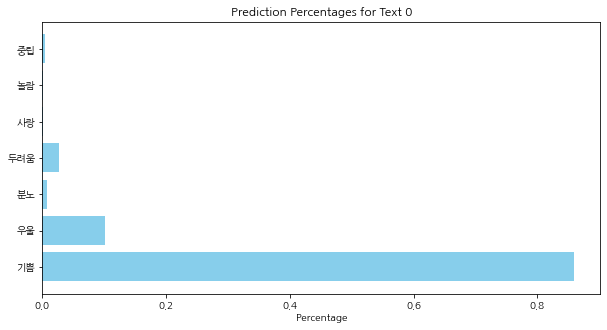

In [33]:
import matplotlib.pyplot as plt

text_index = 102

# Select the row (for example, the first row)
row = result_df.loc[text_index, cols]

# Create a horizontal bar plot
plt.figure(figsize=(10, 5))  # Set the figure size
plt.barh(cols, row, color='skyblue')  # Create a horizontal bar plot
plt.xlabel('Percentage')  # Set the x-label
plt.title('Prediction Percentages for Text 0')  # Set the title
plt.show()  # Display the plot

In [34]:
row

기쁨     0.858965
우울     0.100959
분노     0.007807
두려움    0.027251
사랑     0.000311
놀람      0.00036
중립     0.004348
Name: 102, dtype: object

In [29]:
# Check the classification result of each XLM-RoBERTa Model 
from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)

print("Confusion Matrix")
print(confusion_matrix(df.label, df.pred))
print("-------------------------")
accuracy = accuracy_score(df.label, df.pred)
f1 = f1_score(df.label, df.pred, average='weighted')
recall = recall_score(df.label, df.pred, average='weighted')
precision = precision_score(df.label, df.pred, average='weighted')
print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

Confusion Matrix
[[1202  132   34   28    3    3   89]
 [ 193 2015  204  363    1    1   53]
 [  97  426 1263  125    0    1  281]
 [  77  390  124  849    0    0   99]
 [   6    1    0    0    0    0    0]
 [   5    2    0    0    0    1    1]
 [ 110   63  146   48    0    3  332]]
-------------------------
Accuracy: 0.6455364268612472
F1 score: 0.6449019647823618
Recall: 0.6455364268612472
Precision: 0.650476482979754
